In [1]:
import numpy as np
import matplotlib.pyplot as plt

project = 'july6'
traindate = '2023-08-26'
testdate = '2023-08-27'
traindate_path = '/home/sdybing/gnss-picker/cnn_models_outputs/' + project + '_fq_train/models/traindate_' + traindate + '/'
test_outputs_path = traindate_path + 'data/'
figure_save_dir = traindate_path + 'figures/'
realdata_dir = '/home/sdybing/gnss-picker/data/realdata/summer23/'

realtest_data = np.load(test_outputs_path + testdate + '_realtest_orig_data.npy')
realtest_metadata = np.load(test_outputs_path + testdate + '_realtest_metadata.npy')
realtest_target = np.load(test_outputs_path + testdate + '_realtest_target.npy')
realtest_predictions = np.load(test_outputs_path + testdate + '_realtest_predictions.npy')
rows_w_eqs = np.load(realdata_dir + 'real_metadata_rembad_rows_w_eqs.npy')
# results = np.load(test_outputs_path + 'realtest_metadata_withresults_thresh0025.npy')
# results = np.load(test_outputs_path + 'realtest_metadata_withresults_thresh004.npy')
# results = np.load(test_outputs_path + 'realtest_metadata_withresults_thresh003.npy')
# results = np.load(test_outputs_path + 'realtest_metadata_withresults_thresh005.npy')
results = np.load(test_outputs_path + 'realtest_metadata_withresults_thresh013.npy')

num_realtest = len(realtest_predictions)
# best_thresh = 0.025 # From code 2 - gets all EQs
# best_thresh = 0.04 # Approximate crossover point in code 2
# best_thresh = 0.03
# best_thresh = 0.05
best_thresh = 0.13

# results columns: 
# 0: station name
# 1: date sample came from
# 2: sample start time
# 3: sample end time
# 4: random n counter
# 5: sample P-wave arrives at (gauss pos)
# 6: earthquake magnitude
# 7: result

In [2]:
results.shape

(994155, 8)

In [3]:
realtest_data.shape

(994155, 128, 3)

In [4]:
results[0]

array(['ACSB', '20190704', '2019-07-04T00:00:00.000000Z',
       '2019-07-04T00:02:07.000000Z', '0', 'nan', 'nan', 'true neg'],
      dtype='<U32')

In [5]:
# Calculating PGDs from the waveforms

pgds = []

for i in range(len(realtest_data)):
    
    eqornot = realtest_metadata[i,5]
    if eqornot != 'nan':
        n_data = realtest_data[i,:,0]
        e_data = realtest_data[i,:,1]
        z_data = realtest_data[i,:,2]
        pgd = np.max(np.sqrt((n_data)**2+(e_data)**2+(z_data)**2))
        pgds.append(pgd)
    else:
        pgds.append('nan')

print(np.array(pgds).shape)
np.save(test_outputs_path + 'realtestdata_pgds.npy', np.array(pgds))

(994155,)


In [6]:
# What station and earthquake is associated with the biggest PGD?

i = np.where(np.array(pgds) != 'nan')[0]
maximum = max(np.array(pgds)[i])
print(maximum)

j = np.where(np.array(pgds) == maximum)[0]
print(realtest_metadata[j])

# print(realtest_data[j])
# plt.plot(realtest_data[j][0]);

0.42687295824997146
[['P595' '20190706' '2019-07-06T03:18:58.000000Z'
  '2019-07-06T03:21:05.000000Z' '94' '59' '7.10']]


In [7]:
# Calculating SNRs from the waveforms using the target Gaussian peak as the arrival time

targets_count = []

SNRs_N = []
SNRs_E = []
SNRs_Z = []

for idx in range(len(realtest_target)):
    
    target_min = min(realtest_target[idx,:])
    target_max = max(realtest_target[idx,:])
    target_range = target_max - target_min
    
    if target_range != 0:
        target_max_idx = np.argmax(realtest_target[idx,:])
        targets_count.append(target_max_idx)
    
        p_arrival_index = int(target_max_idx) # The index in the sample that the P-wave arrives at
        
        '''
        In this section, I calculate the signal-to-noise ratio of the data. I 
        aim to use a window of 20 seconds before the P-wave arrival time as the 
        noise, and a window of 20 seconds after the P-wave arrival time as the 
        signal. I take the standard deviation of these segments and divide 
        signal/noise (or after/before) to get the SNR.
        
        Sometimes the P-wave arrival time is too close to the start or end of the
        sample, and this causes issues. I've added conditions for these cases.
        '''
        
        preeq_std_end = p_arrival_index # The end of the 20 second 'noise' section before the earthquake is the P-wave arrival index
        
        if preeq_std_end <= 10: # Ask Diego if this is reasonable # Try 10
        
            # If P-wave pick is at zero - can't calculate a pre-eq standard deviation. 
            # OR the P-wave pick is too close to zero, it throws off the SNR values by a LOT.
            
            SNR_N = 'nan' # Just skip it (at least 10 cases for Z component with weird SNRs - one over 10,000!)
            SNR_E = 'nan'
            SNR_Z = 'nan'
        
        elif preeq_std_end > 10 and preeq_std_end <= 20: # If the pre-earthquake noise window is smaller than 20 seconds...
            
            preeq_std_start = 0
            
            posteq_std_start = p_arrival_index # Start the section for the "signal" at the P-wave arrival index
            posteq_std_end = posteq_std_start + 20
            # posteq_std_end = posteq_std_start + p_arrival_index # If the window before is less than 20 because the arrival time is less than 20, this makes the window after that same length
            
            std_before_N = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,0]) # Take the standard deviation of the sections for each component
            std_after_N = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,0])
            std_before_E = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,1])
            std_after_E = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,1])
            std_before_Z = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,2])
            std_after_Z = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,2])
            
            if std_before_N == 0 or std_before_E == 0 or std_before_Z == 0: # If any of the denominators are zeros, we get 'inf' in the results
                
                SNR_N = 'nan' # Skip 'em
                SNR_E = 'nan'
                SNR_Z = 'nan'
                
            else: # Calculate the SNR
                
                SNR_N = std_after_N / std_before_N
                SNR_E = std_after_E / std_before_E
                SNR_Z = std_after_Z / std_before_Z
        
        elif preeq_std_end > 20 and preeq_std_end <= 108: # Standard case where the P-wave arrival is nicely in the middle somewhere
            
            preeq_std_start = preeq_std_end - 20
            
            posteq_std_start = p_arrival_index
            posteq_std_end = posteq_std_start + 20
        
            std_before_N = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,0]) # Take the standard deviation of the sections for each component
            std_after_N = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,0])
            std_before_E = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,1])
            std_after_E = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,1])
            std_before_Z = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,2])
            std_after_Z = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,2])
            
            if std_before_N == 0 or std_before_E == 0 or std_before_Z == 0:
                
                SNR_N = 'nan'
                SNR_E = 'nan'
                SNR_Z = 'nan'
                
            else:
                
                SNR_N = std_after_N / std_before_N
                SNR_E = std_after_E / std_before_E
                SNR_Z = std_after_Z / std_before_Z
            
        elif preeq_std_end > 108 and preeq_std_end < 128: # End edge case - the "signal" period is less than 20 seconds long
            
            preeq_std_start = preeq_std_end - 20
            
            posteq_std_start = p_arrival_index # Should the below be 127 instead??
            posteq_std_end = posteq_std_start + (128 - p_arrival_index) # Make the signal period end at the end of the sample at 128 to avoid errors
        
            std_before_N = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,0]) # Take the standard deviation of the sections for each component
            std_after_N = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,0])
            std_before_E = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,1])
            std_after_E = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,1])
            std_before_Z = np.std(realtest_data[idx,preeq_std_start:preeq_std_end,2])
            std_after_Z = np.std(realtest_data[idx,posteq_std_start:posteq_std_end,2])
            
            if std_before_N == 0 or std_before_E == 0 or std_before_Z == 0:
                
                SNR_N = 'nan'
                SNR_E = 'nan'
                SNR_Z = 'nan'
                
            else:
                
                SNR_N = std_after_N / std_before_N
                SNR_E = std_after_E / std_before_E
                SNR_Z = std_after_Z / std_before_Z
            
        else: # Covers if the pick is exactly at 128, the end of the sample.
            
            # Can't get a post-eq std because the earthquake arrives at the end of the sample
            
            SNR_N = 'nan' # Skip 'em (5 cases)
            SNR_E = 'nan'
            SNR_Z = 'nan'
            
        '''
        Add the calculated SNRs (or 'nan's for issues) to the lists.
        '''
        
        # if SNR_N == 0:
            
        #     print(idx)
            
        SNRs_N.append(SNR_N)
        SNRs_E.append(SNR_E)
        SNRs_Z.append(SNR_Z)
        
    elif target_range == 0:
        
        SNRs_N.append('nan')
        SNRs_E.append('nan')
        SNRs_Z.append('nan')

print(len(SNRs_N))
print(len(SNRs_E))
print(len(SNRs_Z))


994155
994155
994155


In [8]:
np.save(test_outputs_path + 'realtest_data_SNRs_N.npy', np.array(SNRs_N))
np.save(test_outputs_path + 'realtest_data_SNRs_E.npy', np.array(SNRs_E))
np.save(test_outputs_path + 'realtest_data_SNRs_Z.npy', np.array(SNRs_Z))

In [9]:
# Plots to check and make sure stuff looks right

testmags = []
for ii in range(len(realtest_metadata)):
    mag = realtest_metadata[ii,6]
    if mag == 'nan':
        testmags.append(np.nan)
    else:
        testmags.append(float(mag))
        
testsnrs = []
for iii in range(len(SNRs_N)):
    snr = SNRs_N[iii]
    if snr == 'nan':
        testsnrs.append(np.nan)
    else:
        testsnrs.append(float(snr))
        
testpgds = []
for iiii in range(len(pgds)):
    pgd = pgds[iiii]
    if pgd == 'nan':
        testpgds.append(np.nan)
    else:
        testpgds.append(float(pgd))

logsnrs = np.log10(testsnrs)
logpgds = np.log10(testpgds)

# Remove NaNs to be able to make this quick plot
fixmags = []
numremovedmags = []
for iv in range(len(testmags)):
    mag = testmags[iv]
    if np.isnan(mag):
        numremovedmags.append(1)
    else:
        fixmags.append(mag)    
print('Number of NaN mags removed: ' + str(len(numremovedmags)))
print('Number of good mags left: ' + str(len(fixmags)))

fixpgds = []
numremovedpgds = []
for iv in range(len(logpgds)):
    pgd = logpgds[iv]
    if np.isnan(pgd):
        numremovedpgds.append(1)
    else:
        fixpgds.append(pgd)    
print('Number of NaN PGDs removed: ' + str(len(numremovedpgds)))
print('Number of good PGDs left: ' + str(len(fixpgds)))

fixsnrs = []
numremovedsnrs = []
for iv in range(len(logsnrs)):
    snr = logsnrs[iv]
    if np.isnan(snr):
        numremovedsnrs.append(1)
    elif np.isinf(snr):
        numremovedsnrs.append(1)
    else:
        fixsnrs.append(snr) 
print('Number of NaN SNRs removed: ' + str(len(numremovedsnrs)))
print('Number of good SNRs left: ' + str(len(fixsnrs)))

/tmp/ipykernel_1251644/1058248614.py:27: RuntimeWarning: divide by zero encountered in log10
  logsnrs = np.log10(testsnrs)


Number of NaN mags removed: 992032
Number of good mags left: 2123
Number of NaN PGDs removed: 992032
Number of good PGDs left: 2123
Number of NaN SNRs removed: 992313
Number of good SNRs left: 1842


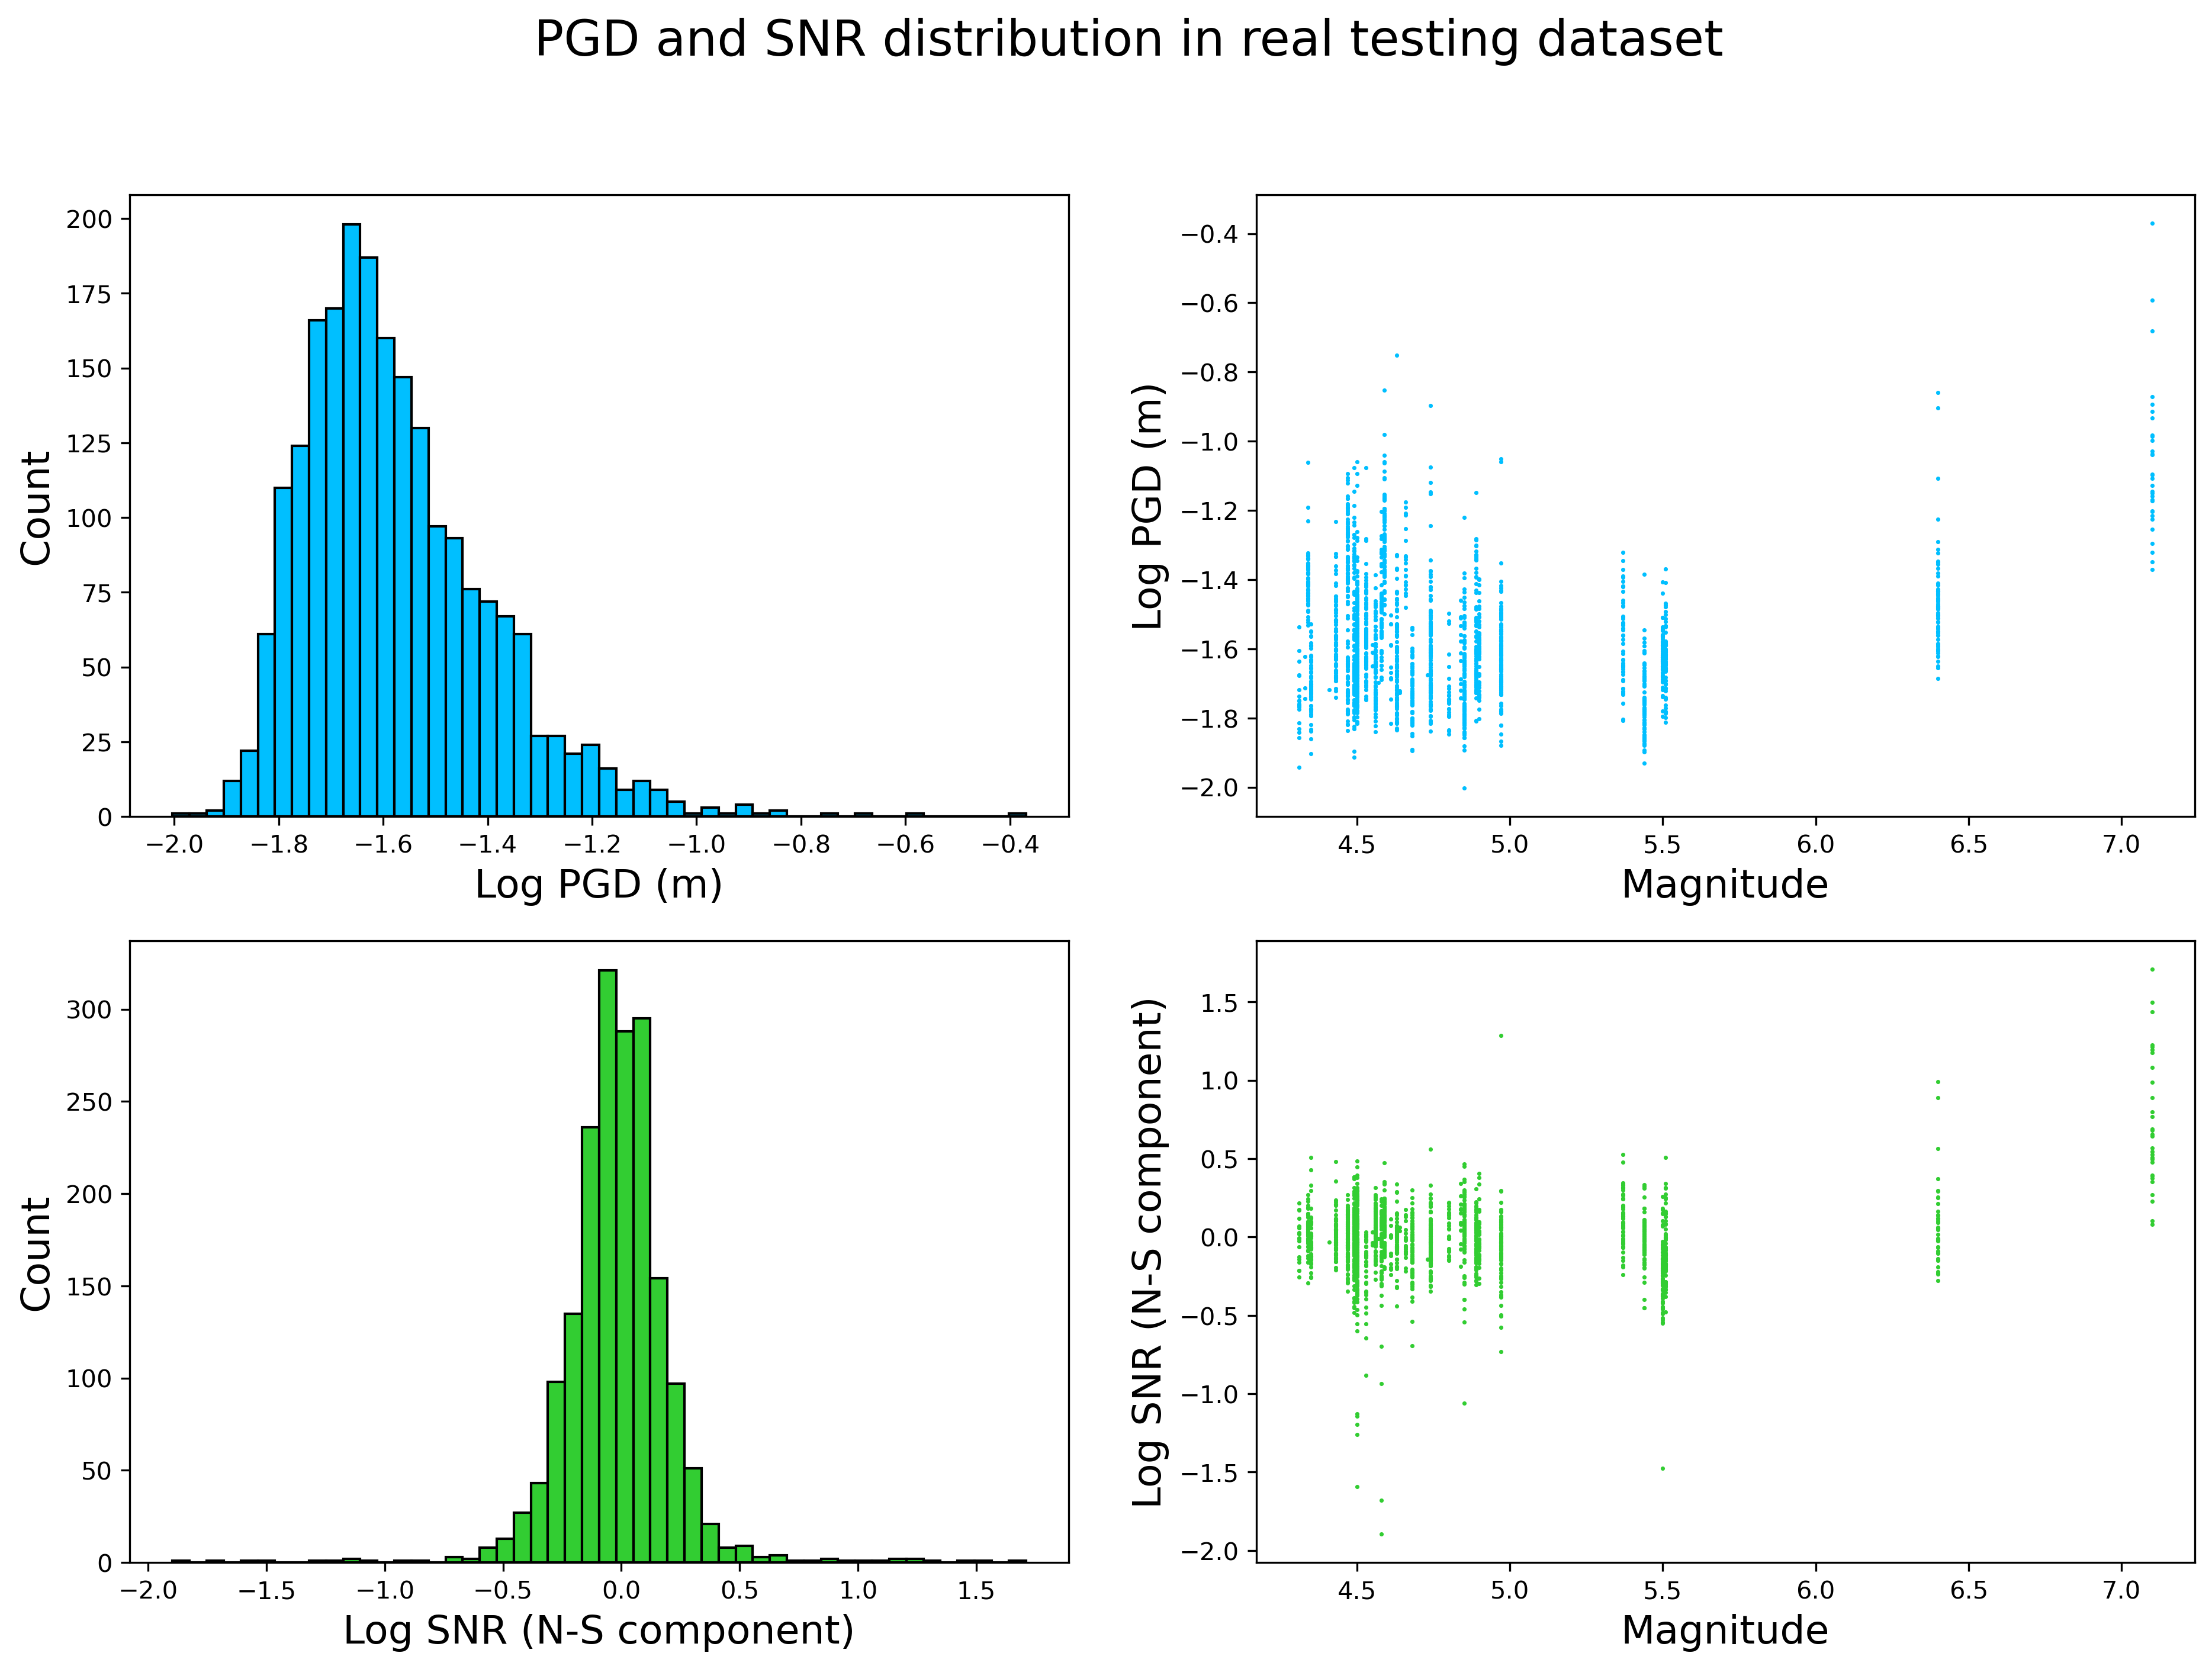

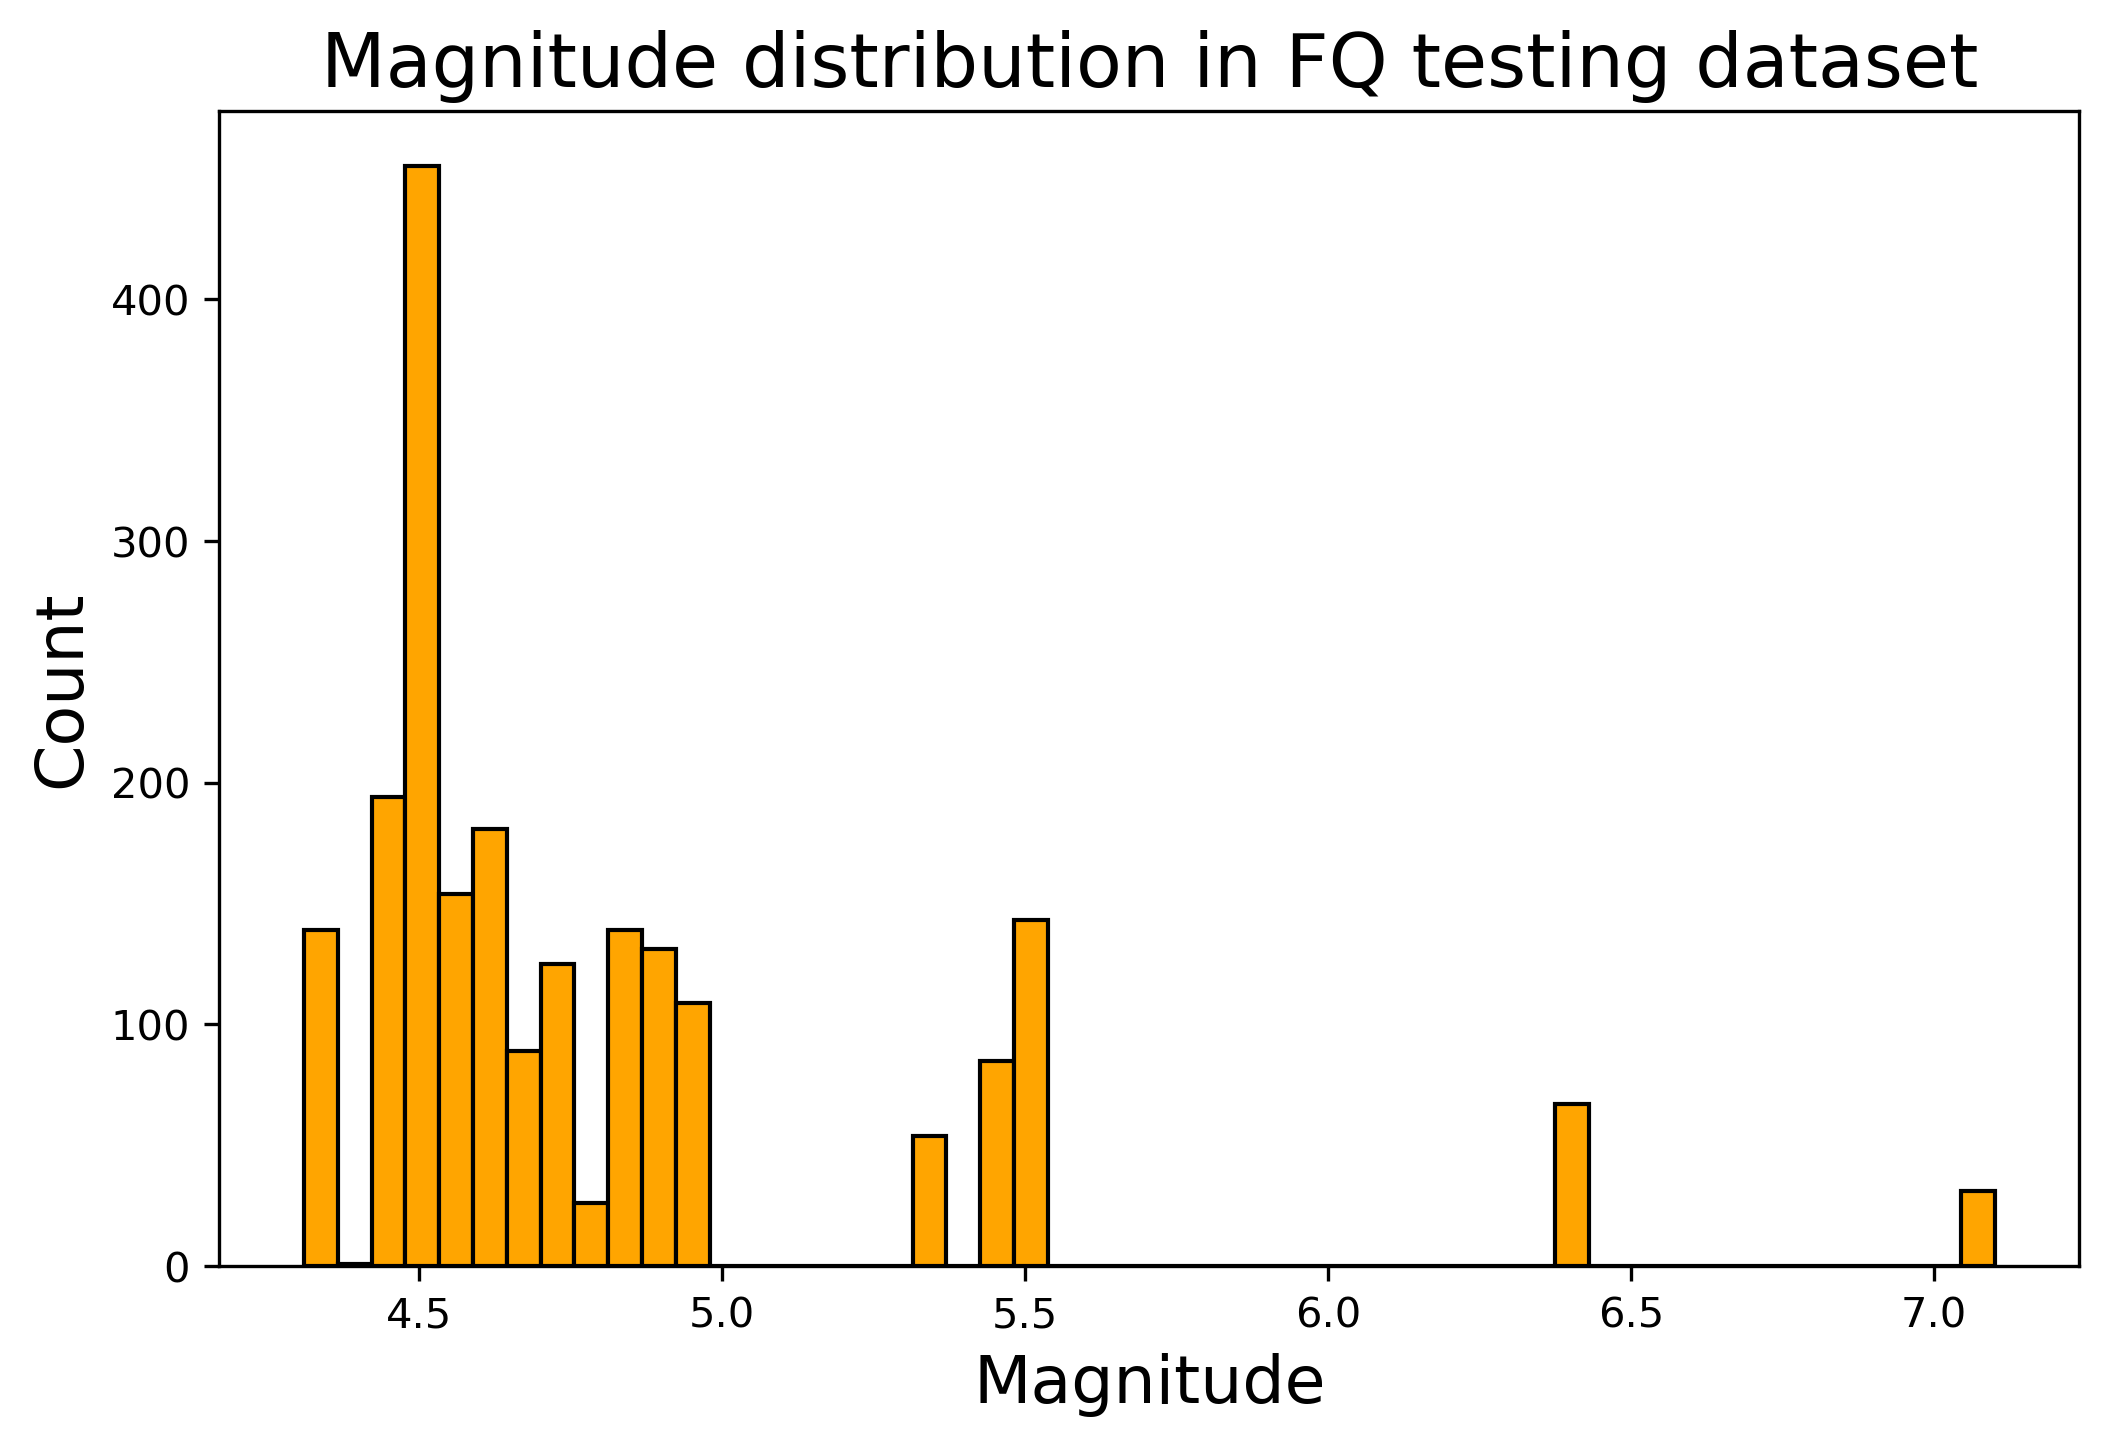

In [10]:
fig = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10), dpi = 300, facecolor = 'white')
plt.suptitle('PGD and SNR distribution in real testing dataset', fontsize = 20)

plt.subplot(2,2,1)
plt.hist(fixpgds, bins = 50, color = 'deepskyblue', edgecolor = 'black')
plt.xlabel('Log PGD (m)', fontsize = 16)
plt.ylabel('Count', fontsize = 16)

plt.subplot(2,2,2)
plt.scatter(testmags, logpgds, s = 0.5, color = 'deepskyblue')
plt.xlabel('Magnitude', fontsize = 16)
plt.ylabel('Log PGD (m)', fontsize = 16)

plt.subplot(2,2,3)
plt.hist(fixsnrs, bins = 50, color = 'limegreen', edgecolor = 'black')
plt.xlabel('Log SNR (N-S component)', fontsize = 16)
plt.ylabel('Count', fontsize = 16)

plt.subplot(2,2,4)
plt.scatter(testmags, logsnrs, s = 0.5, color = 'limegreen')
plt.xlabel('Magnitude', fontsize = 16)
plt.ylabel('Log SNR (N-S component)', fontsize = 16)

plt.show();
# plt.savefig(figure_save_dir + '19a_realtestdata_pgd_and_snr_distribution.png', format = 'PNG')
# plt.close();

plt.figure(figsize = (8,5), facecolor = 'white', dpi = 300)
plt.title('Magnitude distribution in FQ testing dataset', fontsize = 18)
plt.hist(fixmags, bins = 50, color = 'orange', edgecolor = 'black')
plt.xlabel('Magnitude', fontsize = 16)
plt.ylabel('Count', fontsize = 16)

plt.show();
# plt.savefig(figure_save_dir + '19b_realtestdata_magnitude_distribution.png', format = 'PNG')
# plt.close();

In [11]:
# Make a list of indices for rows in the testing dataset that actually have earthquakes
# and for rows that the CNN correctly found those earthquakes

correct_eq_inds = []

for idx in range(len(results)):
       
    if results[idx,7] == 'true pos':
        correct_eq_inds.append(idx)

print(len(rows_w_eqs))
print(len(correct_eq_inds))

np.save(test_outputs_path + 'realtest_data_rows_w_truepos_result_thresh013.npy', np.array(correct_eq_inds))

2123
112


In [12]:
# Add the PGDs and SNRs to the results metadata array

pgds_vector = np.array(pgds).reshape(len(pgds),1) 
a = np.append(results, pgds_vector, axis = 1) 
# Now contains rupture name, station name, magnitude, result, and PGD

SNR_N_vector = np.array(SNRs_N).reshape(len(SNRs_N),1)
SNR_E_vector = np.array(SNRs_E).reshape(len(SNRs_E),1)
SNR_Z_vector = np.array(SNRs_Z).reshape(len(SNRs_Z),1)

b = np.append(a, SNR_N_vector, axis = 1)
c = np.append(b, SNR_E_vector, axis = 1)
new_meta_array = np.append(c, SNR_Z_vector, axis = 1)

print(new_meta_array.shape)
print(new_meta_array[rows_w_eqs][0])

# New metadata array columns:

# 0: station name
# 1: date sample came from
# 2: sample start time
# 3: sample end time
# 4: random n counter
# 5: sample P-wave arrives at (gauss pos)
# 6: earthquake magnitude
# 7: result
# 8: PGD
# 9: SNR N
# 10: SNR E
# 11: SNR Z

# np.save(test_outputs_path + 'realtest_metadata_with_results_pgd_snr_thresh0025.npy', new_meta_array)
np.save(test_outputs_path + 'realtest_metadata_with_results_pgd_snr_thresh013.npy', new_meta_array)

(994155, 12)
['ACSB' '20190706' '2019-07-06T04:37:17.000000Z'
 '2019-07-06T04:39:24.000000Z' '131' '21' '4.85' 'false neg'
 '0.02735077291405581' '1.2427072928702672' '1.813313138629734'
 '0.8877476331580956']


In [13]:
# The following cells aren't useful with the 0.025 threshold because I picked it to get all the real EQs

In [14]:
all_eq_mags = np.asfarray(new_meta_array[rows_w_eqs, 6]) # The magnitudes of all of the earthquakes
correct_eq_mags = np.asfarray(new_meta_array[correct_eq_inds, 6]) # The magnitudes of all the earthquakes the CNN found

all_eq_avg_mag = np.mean(all_eq_mags)
correct_eq_avg_mag = np.mean(correct_eq_mags)

print('Average magnitude of all earthquakes: ' + str(round((all_eq_avg_mag),2)))
print('Average magnitude of earthquakes the CNN correctly found: ' + str(round((correct_eq_avg_mag),2)))

Average magnitude of all earthquakes: 4.82
Average magnitude of earthquakes the CNN correctly found: 5.52


In [15]:
all_eq_pgds = np.asfarray(new_meta_array[rows_w_eqs, 8]) # The PGDs of all of the earthquakes
correct_eq_pgds = np.asfarray(new_meta_array[correct_eq_inds, 8]) # The PGDs of all the earthquakes the CNN found

all_eq_avg_PGD = np.mean(all_eq_pgds)
correct_eq_avg_PGD = np.mean(correct_eq_pgds)

print('Average PGD of all earthquakes: ' + str(round((all_eq_avg_PGD * 100),2)) + ' cm')
print('Average PGD of earthquakes the CNN correctly found: ' + str(round((correct_eq_avg_PGD * 100),2)) + ' cm')

Average PGD of all earthquakes: 2.93 cm
Average PGD of earthquakes the CNN correctly found: 4.76 cm


In [16]:
# Because of the edge cases in the loop above, there are some nans in our SNR vectors.
# We can't calculate averages with nans, so we need to find the rows with nans and
# just remove them for the sake of this calculation.

h = np.where(new_meta_array[rows_w_eqs,9] == 'nan') # Finds nans in SNRN column for all earthquakes
non_nan_rows_w_eqs = np.delete(rows_w_eqs, h) # Removes those rows

j = np.where(new_meta_array[correct_eq_inds,9] == 'nan') # Finds nans in SNRN for the earthquakes the CNN found
non_nan_correct_eq_inds = np.delete(correct_eq_inds, j) # Removes those rows

In [17]:
# Now I just grab the good SNRs out of the new metadata array and calculate the averages.

all_eq_SNR_N = np.asfarray(new_meta_array[non_nan_rows_w_eqs, 9])
all_eq_SNR_E = np.asfarray(new_meta_array[non_nan_rows_w_eqs, 10])
all_eq_SNR_Z = np.asfarray(new_meta_array[non_nan_rows_w_eqs, 11])

correct_eq_SNR_N = np.asfarray(new_meta_array[non_nan_correct_eq_inds, 9])
correct_eq_SNR_E = np.asfarray(new_meta_array[non_nan_correct_eq_inds, 10])
correct_eq_SNR_Z = np.asfarray(new_meta_array[non_nan_correct_eq_inds, 11])

all_eq_SNR_N_avg = np.mean(all_eq_SNR_N)
all_eq_SNR_E_avg = np.mean(all_eq_SNR_E)
all_eq_SNR_Z_avg = np.mean(all_eq_SNR_Z)

correct_eq_SNR_N_avg = np.mean(correct_eq_SNR_N)
correct_eq_SNR_E_avg = np.mean(correct_eq_SNR_E)
correct_eq_SNR_Z_avg = np.mean(correct_eq_SNR_Z)

# print(len(all_eq_SNR_N))
# print(len(correct_eq_SNR_N))

print('Average N-S component SNR of all earthquakes: ' + str(round(all_eq_SNR_N_avg,2)))
print('Average N-S component SNR of earthquakes the CNN correctly found: ' + str(round(correct_eq_SNR_N_avg,2)))
print('-------------------------------------------------------------------')

print('Average E-W component SNR of all earthquakes: ' + str(round(all_eq_SNR_E_avg,2)))
print('Average E-W component SNR of earthquakes the CNN correctly found: ' + str(round(correct_eq_SNR_E_avg,2)))
print('-------------------------------------------------------------------')

print('Average Z component SNR of all earthquakes: ' + str(round(all_eq_SNR_Z_avg,2)))
print('Average Z component SNR of earthquakes the CNN correctly found: ' + str(round(correct_eq_SNR_Z_avg,2)))

Average N-S component SNR of all earthquakes: 1.15
Average N-S component SNR of earthquakes the CNN correctly found: 2.96
-------------------------------------------------------------------
Average E-W component SNR of all earthquakes: 1.29
Average E-W component SNR of earthquakes the CNN correctly found: 4.25
-------------------------------------------------------------------
Average Z component SNR of all earthquakes: 1.09
Average Z component SNR of earthquakes the CNN correctly found: 1.17
